In [36]:
import numpy as np
import scipy as sc
from iminuit import Minuit
import pandas as pd
import scipy.interpolate as interpolate
from scipy.integrate import quad
from matplotlib import colors
from EBL_fit_MC_functions import *
from scipy.stats import norm
from scipy.stats import poisson
import yaml
import matplotlib.pyplot as plt
import h5py
import time
import sys
import os
import uproot
from scipy.stats import norm, chi2
from pathlib import Path

In [37]:
#Source info
Source_name = "Mrk421_20130415c" #'PG1553_ST0203' "1ES1011_Feb2014", 'Mrk421_20130415c', #Check that you have all needed files before running
Source_z = 0.03#0.212
# Observation_time = 42480 #this is only needed for CTA
Emin = 0.06
Emax = 30.#15.

#Telescope
Telescope = "MAGIC" #only MAGIC is well implemented now
#EBL options
EBL_Model = "Dominguez" #there is only one a the moment
alpha_init = 2.0 #positon of the first initial guess.
alpha_min = 0. #lowest EBL scale factor
alpha_max = 2. #hightes EBL scale factor
alpha_step = 0.01 #EBL scale bin size
#Fit function: PWL, LP, freeLP or MBPWL
fit_func_names = ["LP", "MBPWL"]
colors = [ "tab:blue", "red", "tab:green"]

#MBPWL info
Efirst = 0.35#0.379#0.389#0.143#0.11##
DeltaE = 4.606#9.428#3.11#0.211#0.186##
knots = 3

#Ohter options
Background_scale = 1.
Forward_folding = True #FIXME this makes no sense and should be remooved
Norm = 0.25

/home/rgrau/Desktop/EBL-splines/EBL_fit_MC_functions.py:278: RuntimeWarning: divide by zero encountered in log
  logL = np.log(poisson.pmf(Non, mu_gam + mu_bg)) + np.log(poisson.pmf(Noff, Nwobbles * mu_bg)) #change this to sum of logs.(and maybie add gaussian)


<ValueView phi0=5.489300270010916e-05 gamma0=1.6908236402861874 b=-0.31929721312187626>


/home/rgrau/Desktop/EBL-splines/EBL_fit_MC_functions.py:278: RuntimeWarning: divide by zero encountered in log
  logL = np.log(poisson.pmf(Non, mu_gam + mu_bg)) + np.log(poisson.pmf(Noff, Nwobbles * mu_bg)) #change this to sum of logs.(and maybie add gaussian)


<ValueView phi0=5.342326210463652e-05 gamma0=1.7367892129118083 Deltag0=-0.41474188764105524 Deltag1=-0.5550585949967302 Deltag2=-0.9117900340316442>


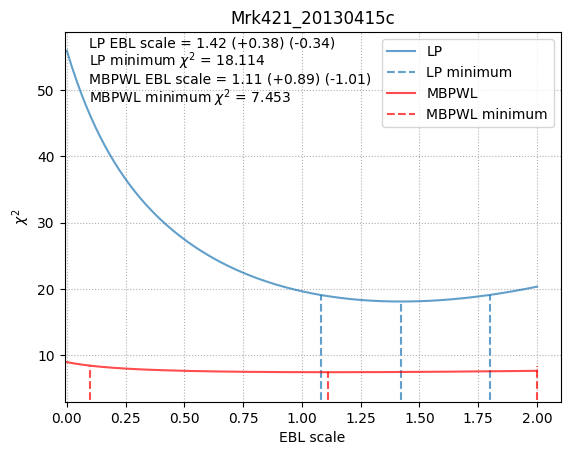

In [38]:
if Source_name == "Mrk421_20130415c":
    data_path = "/home/rgrau/Desktop/EBL_analysis_Feb2018/Mrk421_20130415c/light+00/Output_flute.root"#"/home/rgrau/Desktop/EBL_Gamma2016/EBL_samples/{0}/data/nominal/flute/Output_flute.root".format(Source_name)#"/home/rgrau/Desktop/EBL_Gamma2016/EBL_samples/Mrk421_20130415c/data/nominal/flute/Output_flute.root"
else:
    data_path = "/home/rgrau/Desktop/EBL_analysis_Feb2018/{0}/data/nominal/flute/Output_flute.root".format(Source_name)
f, ax = plt.subplots()
for i, fit_func_name in enumerate(fit_func_names):
    alphas = alphas_creation(alpha_init, alpha_min, alpha_max, alpha_step)

    fit_func = fit_func_select(fit_func_name, knots, Efirst, DeltaE)

    if fit_func_name == "MBPWL":
        if Forward_folding:
            initial_guess_0 = np.zeros(knots+2)
            initial_guess_0[0] = 5e-6
            initial_guess_0[1] = 2.
        else:
            initial_guess_0 = np.zeros(knots+2)
            initial_guess_0[0] = 5e-6
            initial_guess_0[1] = 2.
    elif fit_func_name == "PWL":
        if Forward_folding:
            initial_guess_0 = np.array([5e-6, 2.00])
        else:
            initial_guess_0 = np.array([5e-7, 2.]) #phi_0, gamma
    elif fit_func_name == "LP":
        if Forward_folding:
            initial_guess_0 = np.array([5e-6, 2., 0.])
        else:
            initial_guess_0 = np.array([5e-7, 2., 0.]) #phi_0, alpha, beta
    elif fit_func_name == "freeLP":
        if Forward_folding:
            initial_guess_0 = np.array([5e-6, 2., 0.])
        else:
            initial_guess_0 = np.array([5e-7, 2., 0.]) #phi_0, alpha, beta



    if Telescope == "CTAN_alpha": #this part needs to be changed to include the real CTAN_alpha configuration
        Noffregions = 5
        def m2LogL(params):
            xdata = E_EBL
            mtau = -tau
            mu_gam0 = dNdE_to_mu((fit_func(xdata, params) * np.exp(mtau * alpha))[2:37], Effa_reb, Ebinsw[2:37], Observation_time, Ebins, Eres_reb2, E_EBL[2:37])
            mu_gam = mu_gam0[5:-4]
            mu_bg = mu_BG(mu_gam, Non, Noff, Noffregions)
            min_num_gauss = 20
            conditions = [((Non >= min_num_gauss) & (Noff >= min_num_gauss)), (Non == 0.), (Noff == 0.), (Non != 0.) & (Noff != 0.)]
            choices = [Gauss_logL(Non, Noff, mu_gam, Noffregions), Poisson_logL_Non0(Non, Noff, mu_gam, Noffregions), Poisson_logL_Noff0(Non, Noff, mu_gam, Noffregions), Poisson_logL(Non, Noff, mu_gam, mu_bg, Noffregions)]
            res = np.select(conditions, choices, default = 999999999)
            return np.sum(res)
            
    elif Telescope == "MAGIC":
        Noffregions = 3
        def m2LogL(params):
            xdata = Etrue
            mtau = -tau
            mu_gam = dNdE_to_mu_MAGIC(fit_func(xdata, params) * np.exp(mtau * alpha), Ebinsw_Etrue, migmatval, Eest)
            mu_gam_final = mu_gam[minbin:maxbin]
            Non_final = Non[minbin:maxbin] 
            Noff_final = Noff[minbin:maxbin]
            mu_bg = mu_BG(mu_gam, Non, Noff, Noffregions)
            mu_bg_final = mu_bg[minbin:maxbin]
            min_num_gauss = 20
            conditions = [((Non_final >= min_num_gauss) & (Noff_final >= min_num_gauss)), (Non_final == 0.), (Noff_final == 0.), (Non_final != 0.) & (Noff_final != 0.)]
            choices = [Gauss_logL(Non_final, Noff_final, mu_gam_final, Noffregions), Poisson_logL_Non0(Non_final, Noff_final, mu_gam_final, Noffregions), Poisson_logL_Noff0(Non_final, Noff_final, mu_gam_final, Noffregions), Poisson_logL(Non_final, Noff_final, mu_gam_final, mu_bg_final, Noffregions)]
            res = np.select(conditions, choices, default = 999999999)
            return np.sum(res)

    def fit(initial_guess):

        if fit_func_name == "MBPWL":
            if knots == 1:
                names = ("phi0", "gamma0", "Deltag0", "Eknot")
            else:
                names = ("phi0", "gamma0")
                for i in range(knots):
                    names = names + ("Deltag{0}".format(i),)
        elif fit_func_name == "PWL":
            names = ("phi0", "gamma0")            
        else:
            names = ("phi0", "gamma0", "b")

        m2LogL.errordef = Minuit.LIKELIHOOD
        m = Minuit(m2LogL, initial_guess, name = names)   

        if fit_func_name == "MBPWL": #defines limits to faster and better find the minimum. Can be changed if the intrinsic spectrum function is changed. 
            MBPWL_limits = ([(1e-6, 1e-3), (-4., 5.)])
            errors = [1e-7, 0.01]
            for i in range(knots):
                MBPWL_limits.append(None)
                errors.append(0.01)
            m.limits = MBPWL_limits
        elif fit_func_name == "PWL":
            m.limits = ([(1e-7,1e-3), None]) #TODO canviar això al codi principal
            errors = [1e-7, 0.01]
        else:
            m.limits = ([(1e-7, 1e-3), (-2., None), (None, None)])
            errors = [1e-7, 0.01, 0.01]
        #m.tol = 1e-6
        # m.strategy = 2
        m.errors = errors
        
        m.migrad()
        return m

    # if EBL_Model == "Dominguez": #loads the EBL data of the Dominguez et al 2011 paper.
    #     possible_z = np.array([0.01, 0.02526316, 0.04052632, 0.05578947, 0.07105263, 0.08631579, 0.10157895, 0.11684211, 0.13210526, 0.14736842, 0.16263158, 0.17789474, 0.19315789, 0.20842105, 0.22368421, 0.23894737, 0.25421053, 0.26947368, 0.28473684, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75])
    #     closest_z = find_z(possible_z, Source_z)
    #     file = np.loadtxt('/home/rgrau/Desktop/EBL-splines/tau_dominguez11.out')
    #     pdfile = pd.DataFrame(file)
    #     pdfile = pdfile.rename(columns={ 0 : 'E [TeV]', 1: 'tau z=0.01', 2: 'tau z=0.02526316', 3: 'tau z=0.04052632', 4: 'tau z=0.05578947', 5: 'tau z=0.07105263', 6: 'tau z=0.08631579', 7: 'tau z=0.10157895', 8: 'tau z=0.11684211', 9: 'tau z=0.13210526', 10: 'tau z=0.14736842', 11: 'tau z=0.16263158', 12: 'tau z=0.17789474', 13: 'tau z=0.19315789', 14: 'tau z=0.20842105', 15: 'tau z=0.22368421', 16: 'tau z=0.23894737', 17: 'tau z=0.25421053', 18: 'tau z=0.26947368', 19: 'tau z=0.28473684', 20: 'tau z=0.3' , 21: 'tau z=0.35', 22: 'tau z=0.4' , 23: 'tau z=0.45', 24: 'tau z=0.5', 25: 'tau z=0.55', 26: 'tau z=0.6', 27: 'tau z=0.65', 28: 'tau z=0.7' , 29: 'tau z=0.75'})
    #     E_EBL = pdfile['E [TeV]'].to_numpy() #energy bins
    #     tau_EBL = pdfile['tau z={0}'.format(closest_z)].to_numpy() #tau bins
    # else:
    #     raise Exception('The EBL model "{func}" has not been implemented.'.format(func = EBL_Model))
    if Telescope == "MAGIC": #compute values needed for minimization if the selected telescope is MAGIC
        
        Bckg = uproot.open("{0}:hEstBckgE".format(data_path))#uproot.open(data_path + ":hEstBckgE")#load background values
        bckgmu_final = Bckg.values() #counts in 42480s (can be normalized for any time but as the migmatrix is for that time, only use that time).

        migrmatrix = uproot.open("/home/rgrau/Desktop/EBL-splines/fold_migmatrix_{0}.root:mig_matrix".format(Source_name))
        migmatval = migrmatrix.values() #m^2 * s #values
        migmatxEtrue = migrmatrix.axis("x").edges()/1e3 #TeV #edge values of X axis of the migration matrix (True Energy)
        migmatyEest = migrmatrix.axis("y").edges()/1e3 #TeV #edge values of Y axis of the migration matrix (Estimated Energy)

        Eest = migrmatrix.axis("y").centers()/1e3 #TeV #center values of X axis of the migration matrix (True Energy)
        Etrue = migrmatrix.axis("x").centers()/1e3 #TeV #center values of Y axis of the migration matrix (Estimated Energy)
        E_final = Etrue
        Usedbins = np.where((Emin <= Eest) & (Eest <= Emax))
        minbin = Usedbins[0][0]
        maxbin = Usedbins[0][-1] + 1
        Eest_final = Eest[minbin:maxbin]
        
        tau = tau_interp(Etrue, Source_z, EBL_Model, kind_of_interp = "log")#log_interp1d(E_EBL, tau_EBL, Etrue) #interpolate the tau values to have the same bins as the migration matrix and the data.
        Ebinsw_final = migmatyEest[1:] - migmatyEest[:-1] #compute the bin width of the final energy bins
        Ebinsw_Etrue = migmatxEtrue[1:] - migmatxEtrue[:-1] #compute the bin width of Etrue energy bins

        excess = uproot.open("/home/rgrau/Desktop/EBL-splines/excess_{0}.root:_px".format(Source_name))
        excess_events = excess.values() #Energy bins = Eest

        mu_vec_final = excess_events
    #change to scan alphas

    def process2(alphas, mu_on, mu_off):
        chisqs = []
        chi_bf = 9999999
        global alpha, Non, Noff
        alpha = alpha_init
        Non, Noff = np.round(mu_on), np.round(Noffregions * mu_off)
        Non_u, Noff_u = np.sqrt(Non), np.sqrt(Noff)
        things = fit(initial_guess=initial_guess_0)
        if things.valid == False:
            raise Warning("The minimum is not valid")
        initial_guess_mat = ig_mat_create(fit_func_name, alphas, knots)
        initial_guess_mat[0] = things.values
        for i, alpha0 in enumerate(alphas):
            alpha = alpha0
            initial_guess = initial_guess_mat[i]
            if alpha == alpha_init:
                initial_guess = initial_guess_mat[0]
            things = fit(initial_guess = initial_guess)
            if things.valid == False:
                raise Warning("The minimum is not valid")
            if i < len(alphas):
                initial_guess_mat[i+1] = things.values
            chi2 = m2LogL(things.values)
            chisqs.append(chi2)
            if chi_bf > chi2:
                chi_bf = chi2
                bestfit = things.values
        return chisqs, bestfit

    mu_on = mu_vec_final + bckgmu_final
    mu_off = bckgmu_final 
    chisqs, bestfit = process2(alphas, mu_on, mu_off)
    print(bestfit)
    #plot of chi2 vs alpha
    order = np.argsort(alphas)
    alphas2 = np.take_along_axis(alphas, order, axis=-1)
    chisqs2 = np.take_along_axis(np.array(chisqs), order, axis=-1)
    minimum = np.round(alphas2[np.where(chisqs2 == np.min(chisqs2))][0], decimals = 3)
    sigma_inter_1s = np.where(chisqs2 <= 1 + np.min(chisqs2))
    upper_bound = np.round(alphas2[np.max(sigma_inter_1s)], decimals = 3)
    lower_bound = np.round(alphas2[np.min(sigma_inter_1s)], decimals = 3)

    plt.plot(alphas2, chisqs2, label = fit_func_name, color = colors[i], alpha = 0.7)
    plt.vlines(minimum, ymin = 0, ymax = np.min(chisqs2), linestyle = "--", color = colors[i], alpha = 0.7, label = "{0} minimum".format(fit_func_name))
    plt.vlines(upper_bound, ymin = 0, ymax = np.min(chisqs2)+1, linestyle = "--", color = colors[i], alpha = 0.7)
    plt.vlines(lower_bound, ymin = 0, ymax = np.min(chisqs2)+1, linestyle = "--", color = colors[i], alpha = 0.7)

    plt.text(x = 0.05, y = 0.99 - 0.1 * i, s="{func} EBL scale = {0} (+{1}) (-{2})".format(minimum, np.round(upper_bound-minimum, decimals = 3), np.round(minimum-lower_bound, decimals = 3), func=fit_func_name),
     ha='left', va='top', transform=ax.transAxes)
    plt.text(x = 0.05, y = 0.95 - 0.1 * i, s = r"{func} minimum $\chi^2$ = {0}".format(np.round(np.min(chisqs2), decimals = 3), func = fit_func_name),
     ha='left', va='top', transform=ax.transAxes)

plt.xlabel("EBL scale")
plt.ylabel(r"$\chi^2$")
plt.grid(linestyle = ":")
plt.xlim(-0.01,None)
plt.ylim(3, None)
plt.title(Source_name)
plt.legend(loc = "upper right")
# plt.savefig("Plots/{0}SED.jpg".format(Source_name))
plt.show()

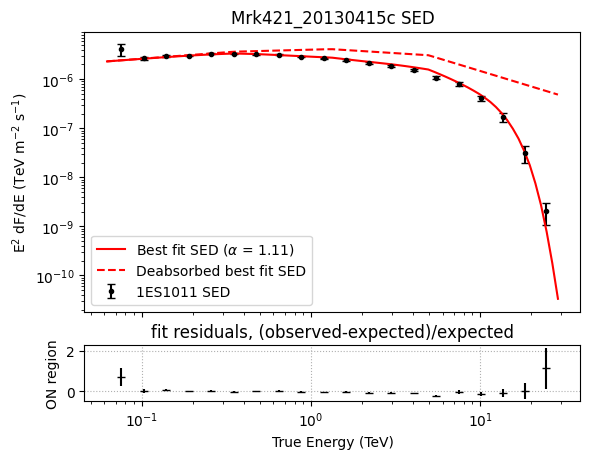

In [39]:
#FIXME change to the best fit alpha
alpha = minimum
mtau = -tau
Data = uproot.open(data_path + ":DiffEspectrum")
Data_values = Data.values()
dNdE_u = Data.errors("mean")[1]
dNdE = Data_values[1] # 1/ cm^2 / s / TeV
Eest_data = Data_values[0] * 1e-3 #TeV
mtau2 = -tau_interp(Eest_data, Source_z, EBL_Model, kind_of_interp = "log")#-log_interp1d(E_EBL, tau_EBL, Eest_data)
SED_orig = Eest_data * Eest_data * dNdE * 1e4 #put it in 1/m^2 instead of 1/cm^2
SED_orig_u = Eest_data *  Eest_data * dNdE_u *1e4
SED_fit = fit_func(Etrue, bestfit) * np.exp(mtau * alpha) * Etrue * Etrue
SED_fit_deabs = fit_func(Etrue, bestfit) * Etrue * Etrue
SED_fit2 = fit_func(Eest_data, bestfit) * np.exp(mtau2 * alpha) * Eest_data * Eest_data
binw = np.zeros(len(Eest)-1)

Etrue_bins = np.where((Emin <= Etrue) & (Etrue <= Emax))
minbin_tr = Etrue_bins[0][0]
maxbin_tr = Etrue_bins[0][-1] + 1

f, (ax1, ax2) = plt.subplots(2, 1, gridspec_kw={'height_ratios': [5, 1]}, sharex=True)
ax1.errorbar(Eest_data, SED_orig, yerr= SED_orig_u, fmt = ".", capsize = 3, label = "1ES1011 SED", color = "black")
# ax1.errorbar(Eest_final, SED_orig, yerr=SED_orig_u, fmt = ".", label = "Assimov dataset SED")
ax1.plot(Etrue[minbin_tr:maxbin_tr], SED_fit[minbin_tr:maxbin_tr], label = r"Best fit SED ($\alpha$ = {0})".format(alpha), color = 'red')
ax1.plot(Etrue[minbin_tr:maxbin_tr], SED_fit_deabs[minbin_tr:maxbin_tr], linestyle = "--", label = "Deabsorbed best fit SED", color = 'red')
ax1.set_xscale('log')
ax1.set_yscale('log')
ax2.set_xlabel("True Energy (TeV)")
ax1.set_ylabel(r"E$^2$ dF/dE (TeV m$^{-2}$ s$^{-1}$)")
ax1.set_title("{0} SED".format(Source_name))
ax1.legend()
ax2.errorbar(Eest_data, (SED_orig - SED_fit2) / SED_fit2 , yerr= SED_orig_u / SED_fit2, fmt = "_",  color = "black")
# ax2.axhline(color = "black")
ax2.set_title("fit residuals, (observed-expected)/expected")
ax2.set_ylabel("ON region")
ax2.grid(linestyle = ":")
# ax2.set_yscale('log')
plt.show()

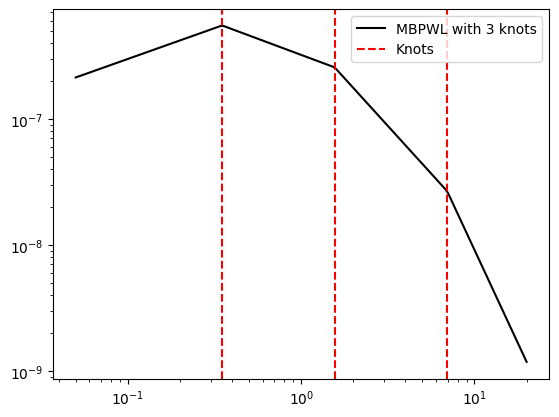

In [40]:
MBPWL = fit_func_select("MBPWL", knots = 3, Efirst = Efirst, DeltaE = DeltaE+2)
Energy_plot = np.geomspace(5e-2, 2.e1, 150)
Ebr = np.geomspace(Efirst, Efirst+ DeltaE+2, 3)
SED_fitplot = MBPWL(Energy_plot, np.array([7.471428040974111e-06, 1.5119396033218624, 1., 1., 1.2])) * np.square(Energy_plot)
plt.plot(Energy_plot, SED_fitplot, color = 'black', label = "MBPWL with 3 knots")
plt.axvline(Efirst, label = "Knots", color = "red", linestyle = "--")
plt.axvline(Ebr[1], color = "red", linestyle = "--")
plt.axvline(Ebr[2], color = "red", linestyle = "--")
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.show()

Example of EBL absorption:

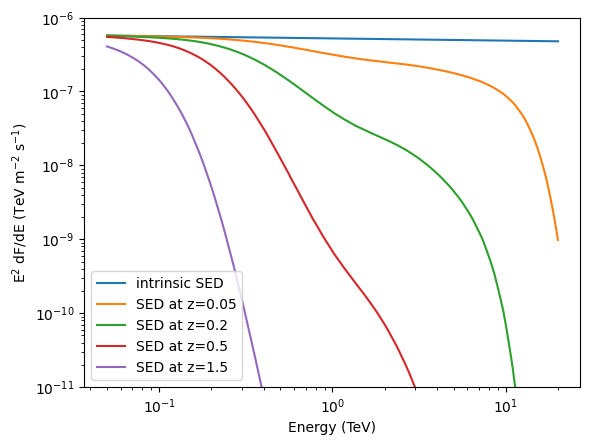

In [41]:
redshifts = [0., 0.05, 0.2, 0.5, 1.5]
PWL = fit_func_select("PWL")
Energy_plot = np.geomspace(5e-2, 2.e1, 150)
for i in redshifts:
    if i == 0.:
        SED_plot = PWL(Energy_plot, [8.7e-6, 2.03]) * np.square(Energy_plot)
        plt.plot(Energy_plot, SED_plot, label = 'intrinsic SED'.format(i))
    else:
        tau2 = tau_interp(Energy_plot, i, "Dominguez", kind_of_interp = "log")
        SED_plot = PWL(Energy_plot, [8.7e-6, 2.03]) * np.exp(-tau2) * np.square(Energy_plot)
        plt.plot(Energy_plot, SED_plot, label = 'SED at z={0}'.format(i))

plt.legend()
plt.xscale('log')
plt.yscale('log')
plt.ylim(1e-11, 1e-6)
plt.xlabel('Energy (TeV)')
plt.ylabel(r"E$^2$ dF/dE (TeV m$^{-2}$ s$^{-1}$)")
plt.show()